In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
import numpy as np
from scipy.linalg import block_diag, sqrtm
from bao import BAOCosmology,BAOLikelihood,BAOLikelihood_sys
import pocomc as pc
from scipy.stats import uniform,norm

In [4]:
def combine_covariances(A, B, R):
    sqrtA = sqrtm(A)
    sqrtB = sqrtm(B)
    sqrtA = np.real(sqrtA)
    sqrtB = np.real(sqrtB)
    C = R * np.dot(sqrtA, sqrtB)
    M = np.block([[A, C],
                  [C.T, B]])
    return M

In [5]:
desitracers=['BGS_BRIGHT-21.5_GCcomb_z0.1-0.4',
             'LRG_GCcomb_z0.4-0.6',
             'LRG_GCcomb_z0.6-0.8',
             'LRG+ELG_LOPnotqso_GCcomb_z0.8-1.1',
             'ELG_LOPnotqso_GCcomb_z1.1-1.6',
             'QSO_GCcomb_z0.8-2.1',
             'Lya_GCcomb'
            ]
desizeffs=[0.295,0.51,0.706,0.930,1.317,1.491,2.33]
desimodes=['1d','2d','2d','2d','2d','1d','2d']
sdsstracers=['DR12_LRG','DR16_LRG']
sdsszeffs=[0.51,0.698]
R=[0.35,0.21]

data={}
for itr,tracer in enumerate(desitracers):
    data[tracer]={}
    data[tracer]['data']=np.loadtxt('bao_data/desi_2024_gaussian_bao_'+tracer+'_mean.txt',usecols=1)
    data[tracer]['zeff']=np.loadtxt('bao_data/desi_2024_gaussian_bao_'+tracer+'_mean.txt',usecols=0)
    data[tracer]['type']=np.loadtxt('bao_data/desi_2024_gaussian_bao_'+tracer+'_mean.txt',usecols=2, dtype=str)
    data[tracer]['cov']=np.loadtxt('bao_data/desi_2024_gaussian_bao_'+tracer+'_cov.txt')
data['DR12_LRG']={}
data['DR16_LRG']={}
data['DR12_LRG']['data']=np.loadtxt('bao_data/sdss_DR12_LRG_BAO_DMDH.dat',usecols=1)[2:]
data['DR12_LRG']['zeff']=np.loadtxt('bao_data/sdss_DR12_LRG_BAO_DMDH.dat',usecols=0)[2:]
data['DR12_LRG']['type']=np.loadtxt('bao_data/sdss_DR12_LRG_BAO_DMDH.dat',usecols=2, dtype=str)[2:]
data['DR12_LRG']['cov']=np.loadtxt('bao_data/sdss_DR12_LRG_BAO_DMDH_covtot.txt')[2:,2:]
data['DR16_LRG']['data']=np.loadtxt('bao_data/sdss_DR16_LRG_BAO_DMDH.dat',usecols=1)
data['DR16_LRG']['zeff']=np.loadtxt('bao_data/sdss_DR16_LRG_BAO_DMDH.dat',usecols=0)
data['DR16_LRG']['type']=np.loadtxt('bao_data/sdss_DR16_LRG_BAO_DMDH.dat',usecols=2, dtype=str)
data['DR16_LRG']['cov']=np.loadtxt('bao_data/sdss_DR16_LRG_BAO_DMDH_covtot.txt')
data['combined_LRG1']={}
data['combined_LRG2']={}
data['combined_LRG1']['data']=np.concatenate((data['LRG_GCcomb_z0.4-0.6']['data'],data['DR12_LRG']['data']))
data['combined_LRG2']['data']=np.concatenate((data['LRG_GCcomb_z0.6-0.8']['data'],data['DR16_LRG']['data']))
data['combined_LRG1']['zeff']=np.concatenate((data['LRG_GCcomb_z0.4-0.6']['zeff'],data['DR12_LRG']['zeff']))
data['combined_LRG2']['zeff']=np.concatenate((data['LRG_GCcomb_z0.6-0.8']['zeff'],data['DR16_LRG']['zeff']))
data['combined_LRG1']['type']=np.concatenate((data['LRG_GCcomb_z0.4-0.6']['type'],data['DR12_LRG']['type']))
data['combined_LRG2']['type']=np.concatenate((data['LRG_GCcomb_z0.6-0.8']['type'],data['DR16_LRG']['type']))
data['combined_LRG1']['cov']=combine_covariances(data['LRG_GCcomb_z0.4-0.6']['cov'],data['DR12_LRG']['cov'],R[0])
data['combined_LRG2']['cov']=combine_covariances(data['LRG_GCcomb_z0.6-0.8']['cov'],data['DR16_LRG']['cov'],R[1])

In [6]:
combined_tracers=desitracers.copy()
combined_tracers[1:3]=['combined_LRG1','combined_LRG2']
data['DESI_SDSS']={}
data['DESI_SDSS']['data'] = np.concatenate(([np.atleast_1d(data[tracer]['data']) for tracer in combined_tracers]))
data['DESI_SDSS']['cov']= block_diag(*[data[tracer]['cov'] for tracer in combined_tracers])
data['DESI_SDSS']['zeff']= np.concatenate(([np.atleast_1d(data[tracer]['zeff']) for tracer in combined_tracers]))
data['DESI_SDSS']['type']= np.concatenate(([np.atleast_1d(data[tracer]['type']) for tracer in combined_tracers]))

In [26]:
bounds=[[-3,1],[-3,2],[0.01,0.99],[0.005,0.1],[0.2,1]]
bounds_sys=[[-3,1],[-3,2],[0.01,0.99],[0.005,0.1],[0.2,1],[1,9]]

In [8]:
bao_like = BAOLikelihood(data['DESI_SDSS']['data'], data['DESI_SDSS']['cov'], data['DESI_SDSS']['zeff'], data['DESI_SDSS']['type'], engine='camb')

In [9]:
bao_like_sys = BAOLikelihood_sys(data['DESI_SDSS']['data'], data['DESI_SDSS']['cov'], data['DESI_SDSS']['zeff'], data['DESI_SDSS']['type'], engine='camb')

In [69]:
def prepPrior(bound, bbn=None):
    dists = [
        norm(bbn[0], bbn[1]) if idx == 3 and bbn is not None 
        else uniform(lower, upper - lower)
        for idx, (lower, upper) in enumerate(bound)
    ]
    return pc.Prior(dists)
prior=prepPrior(bounds,[0.02218, 0.00055])
prior_nobbn=prepPrior(bounds)

In [27]:
def prepPrior_sys(bound, bbn=None):
    dists = [
        norm(bbn[0], bbn[1]) if idx == 3 and bbn is not None 
        else uniform(lower, upper - lower)
        for idx, (lower, upper) in enumerate(bound)
    ]
    return pc.Prior(dists)
prior_sys=prepPrior(bounds_sys,[0.02218, 0.00055])

In [81]:
import multiprocessing as mp

if __name__ == '__main__':
    mp.set_start_method('spawn', force=True)
    
    # Now define your prior, bao_like, etc.
    sampler = pc.Sampler(
        prior=prior,
        likelihood=bao_like.log_likelihood,
        vectorize=False,
        pool=10,
        output_dir='chains/',
        output_label='test'
    )
    sampler_sys = pc.Sampler(
        prior=prior_sys,
        likelihood=bao_like_sys.log_likelihood,
        vectorize=False,
        pool=10,
        output_dir='chains/',
        output_label='test_sys'
    )

/opt/homebrew/Caskroom/miniconda/base/envs/general/lib/python3.11/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [13]:
sampler.run()

Iter: 30it [01:54,  3.82s/it, beta=1, calls=39936, ESS=4079, logZ=-18.3, logP=-6.86, acc=0.805, steps=6, eff=0.93]   


In [29]:
sampler_sys.run()


Iter: 0it [00:00, ?it/s]
Iter: 0it [00:00, ?it/s, beta=0, calls=0, ESS=512, logZ=0, logP=0, acc=0, steps=0, eff=0]
Iter: 0it [00:00, ?it/s, beta=0, calls=256, ESS=512, logZ=0, logP=-1.07e+3, acc=1, steps=1, eff=1]
Iter: 1it [00:00,  2.72it/s, beta=0, calls=256, ESS=512, logZ=0, logP=-1.07e+3, acc=1, steps=1, eff=1]
Iter: 1it [00:00,  2.72it/s, beta=0, calls=512, ESS=512, logZ=0, logP=-1.07e+3, acc=1, steps=1, eff=1]
Iter: 2it [00:00,  2.65it/s, beta=0, calls=512, ESS=512, logZ=0, logP=-1.07e+3, acc=1, steps=1, eff=1]
Iter: 2it [00:01,  2.65it/s, beta=0, calls=768, ESS=512, logZ=0, logP=-1.23e+3, acc=1, steps=1, eff=1]
Iter: 3it [00:01,  2.75it/s, beta=0, calls=768, ESS=512, logZ=0, logP=-1.23e+3, acc=1, steps=1, eff=1]
Iter: 3it [00:01,  2.75it/s, beta=0, calls=1024, ESS=512, logZ=0, logP=-1.25e+3, acc=1, steps=1, eff=1]
Iter: 4it [00:01,  2.84it/s, beta=0, calls=1024, ESS=512, logZ=0, logP=-1.25e+3, acc=1, steps=1, eff=1]
Iter: 5it [00:01,  2.84it/s, beta=0.00781, calls=1024, ESS=516

In [14]:
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt

In [35]:
labels = ['w_0','w_a','\Omega_m','\omega_b','h'] 
names = ['w','wa','OmegaM','omegab','h']
labels_sys = ['w_0','w_a','\Omega_m','\omega_b','h','sys'] 
names_sys = ['w','wa','OmegaM','omegab','h','sys']

#samples_gd  = samp2gd(sampler.posterior(),names,labels,label='no sys')
samples_sys_gd  = samp2gd(sampler_sys.posterior(),names_sys,labels_sys,label='sys')


Removed no burn in


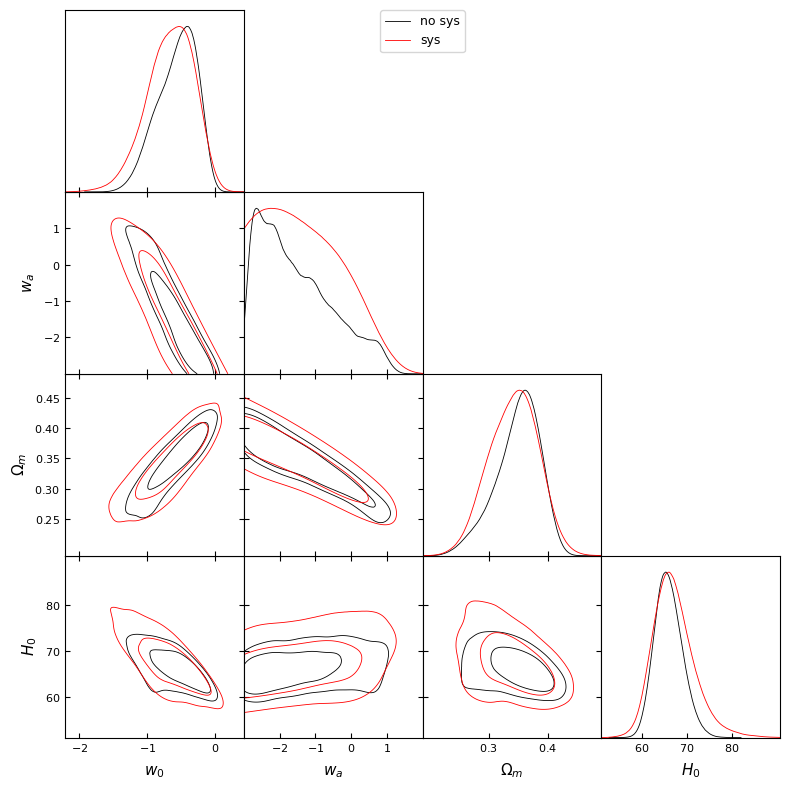

In [39]:
g = plots.get_subplot_plotter()
g.triangle_plot([samples_gd,samples_sys_gd], ['w','wa','OmegaM','H0'],filled=False)

In [32]:
def samp2gd(post,names,labels,label=None):
    samples, weights, logl, logp=post
    bounds=[[-3,1],[-3,2],[0.01,0.99],[0.005,0.1],[0.2,1]]
    ranges={}
    if 'w' in names:
        ranges['w']=[-3,1]
    if 'wa' in names:        
        ranges['wa']=[-3,2]
    if 'OmegaM' in names:
        ranges['OmegaM']=[0.01,0.99]
    if 'omegab' in names:
        ranges['omegab'] = [0.005,0.1]
    if 'h' in names:
        ranges['h'] = [0.2,1]
    if 'sys' in names:
        ranges['sys'] = [1,9]
    
    gdsamp=MCSamples(samples=samples, weights = weights, names = names, labels = labels, label = label, ranges=ranges)
    p=gdsamp.getParams()
    gdsamp.addDerived(p.h*100.,name='H0',label='H_0',range=[20,100])
    return gdsamp

In [72]:
from cmb import CMBCompressedLikelihood

In [73]:
cmb_vec=[0.01041027, 0.02223208, 0.14207901]
cmb_cov=[[ 6.62099420e-12,  1.24442058e-10, -1.19287532e-09], [ 1.24442058e-10,  2.13441666e-08, -9.40008323e-08], [-1.19287532e-09, -9.40008323e-08,  1.48841714e-06]]

In [74]:
cmbcompressed=CMBCompressedLikelihood(cmb_vec,cmb_cov)

In [75]:
cmbcompressed.log_likelihood([-1,0,0.313,0.022,0.68])

-189.9159960317548

In [76]:
def combinedlike(params,baolike,cmblike):
    return baolike.log_likelihood(params)+cmblike.log_likelihood(params)

In [77]:
if __name__ == '__main__':
    mp.set_start_method('spawn', force=True)
    
    # Now define your prior, bao_like, etc.
    sampler_cmb = pc.Sampler(
        prior=prior_nobbn,
        likelihood=combinedlike,
        vectorize=False,
        pool=10,
        output_dir='chains/',
        output_label='test_cmb',
        likelihood_kwargs={'baolike':bao_like,'cmblike':cmbcompressed}
    )

In [78]:
sampler_cmb.run()


Iter: 0it [00:00, ?it/s]
Iter: 0it [00:00, ?it/s, beta=0, calls=0, ESS=512, logZ=0, logP=0, acc=0, steps=0, eff=0]
Iter: 0it [00:00, ?it/s, beta=0, calls=256, ESS=512, logZ=0, logP=-3.67e+5, acc=1, steps=1, eff=1]
Iter: 1it [00:00,  1.66it/s, beta=0, calls=256, ESS=512, logZ=0, logP=-3.67e+5, acc=1, steps=1, eff=1]
Iter: 1it [00:01,  1.66it/s, beta=0, calls=512, ESS=512, logZ=0, logP=-5.05e+5, acc=1, steps=1, eff=1]
Iter: 2it [00:01,  1.56it/s, beta=0, calls=512, ESS=512, logZ=0, logP=-5.05e+5, acc=1, steps=1, eff=1]
Iter: 2it [00:01,  1.56it/s, beta=0, calls=768, ESS=512, logZ=0, logP=-6.03e+5, acc=1, steps=1, eff=1]
Iter: 3it [00:01,  1.64it/s, beta=0, calls=768, ESS=512, logZ=0, logP=-6.03e+5, acc=1, steps=1, eff=1]
Iter: 3it [00:02,  1.64it/s, beta=0, calls=1024, ESS=512, logZ=0, logP=-4.35e+5, acc=1, steps=1, eff=1]
Iter: 4it [00:02,  1.60it/s, beta=0, calls=1024, ESS=512, logZ=0, logP=-4.35e+5, acc=1, steps=1, eff=1]
Iter: 5it [00:02,  1.60it/s, beta=5.96e-6, calls=1024, ESS=514

In [79]:
samples_cmb_gd  = samp2gd(sampler_cmb.posterior(),names,labels,label='cmb nosys')


Removed no burn in


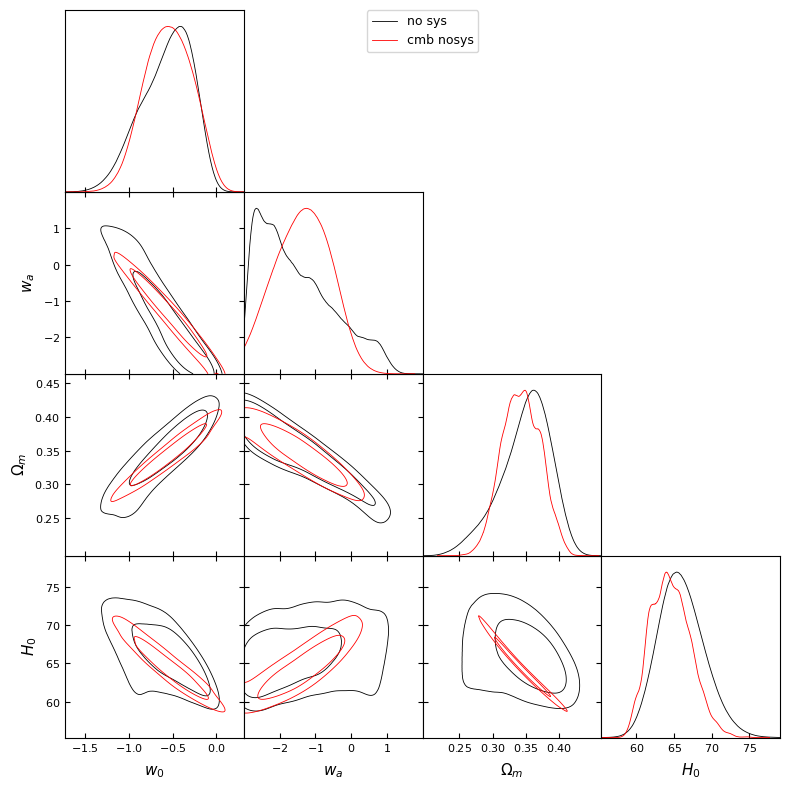

In [80]:
g = plots.get_subplot_plotter()
g.triangle_plot([samples_gd,samples_cmb_gd], ['w','wa','OmegaM','H0'],filled=False)